In [1]:
import numpy as np
import gurobipy as gb
import pylab as pl

import seaborn as sns
sns.set_theme()

from src import *

# TSDAP
## Time Dependent Activity Scheduling Problem

### Problem definition



$\tau_i(t_i)$ is the time required to complete activity $i$ at time $t_i$.  
$e_i, l_i$ are the earliest start time and latest end time of activity $i$.  
$\rho_i(t_i)$ is the resource consumption of activity $i$ at time $t_i$.  
$Q$ is the total resource capacity  
$\theta_i(t_i) = t_i + \tau_i(t_i)$ is the completion time function.  

Minimize
$$\min_{t_j} \theta_n(t_n) = \min_{t_j} t_n + \tau_n(t_n)$$

subject to
$$\theta_i(t_i) \le t_{i+1}$$
$$\sum_{i=1}^{n} \rho_i(t_i) \le Q$$
$$t_i \in [e_i, l_i]$$

We assume the FIFO property: $\theta_i(t) \le \theta_i(t')$ if $t \le t'$

#### Solve TSDAP

$V_i = \{e_i, e_i + \epsilon, ..., l_i \}$ set of vertices for activity $i$  
$V = V_1 \cup ... \cup V_n$  
$q_{(i,t)} = \rho_i(t)$  
$l_{(i,t)}$ cumulative resource consumption prior to starting activity $i$ at time $t_i$.  
$W = \{(i, t) \in V \setminus \bar V \; | \; l_{(i, t)} + q_{(i,t)} \le Q\}$ set of still available vertices.


![](algorithm_1.png)

#### Implemented solution

The implemented algorithm differs from the one described in the paper by using a MinHeap to store the vertexes $W$ instead of a sorted list. This choice was made by analyzing the time complexity of the two algorithms, the sorted list has complexity $O(n^2m^2)$, while the MinHeap has complexity $O(nm(m+\log(mn)))$ and if we assume $n=am, \; a>0$ which is the case of the article, the complexity reduces to $O(nm^2)$. This enhanced version of the algorithm has also been discussed with the authors of the paper, who agree on the complexity.  

### Data Model

We consider the problem of delivering n packages in a big city with time-dependent congestions. We assume that the delivery order of the packages has already been optimized by a routing algorithm and we seek a further optimization as to when to start each delivery in order to complete all of them as soon as possible.

We generate the data as follows:  
* The city is modelled as a traffic distribution over 2D space, which is peaked at the center of the city, and a traffic distribution over time, with two peaks during rush hours (8am and 5pm).
* The congestion level is a function of both these two functions and is computed as follows: 
```python
traffic = 1 / (1 - traffic_over_time(time))
sensitivity = traffic_over_space(point)
congestion = min(traffic*sensitivity + 1-sensitivity, 5)
```

The least amount of congestion is 1 while the maximum amount is capped at 5.  
The idea is that the traffic varies over time in the whole city, however, the intensity of the traffic is felt less and less the further you go away from the city center.  

####  Traffic over time
shape taken from https://www.tomtom.com/en_gb/traffic-index/new-york-traffic/

Text(0.5, 0, 'Time of day [hours]')

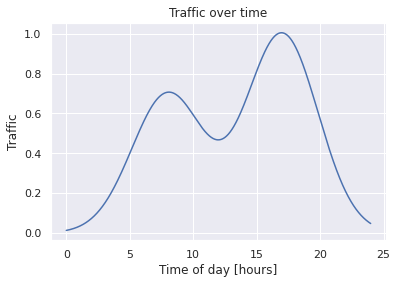

In [4]:
t = np.arange(0, 24*60)
pl.plot(t/60, traffic_over_time(t))
pl.title("Traffic over time")
pl.ylabel("Traffic")
pl.xlabel("Time of day [hours]")

#### Traffic over space  
A gaussian distribution centered around (0, 0)

/tmp/ipykernel_5917/1120431300.py:5: UserWarning: The following kwargs were not used by contour: 'figsize'
  pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100, figsize=(5,5))


Text(0.5, 0, 'x [km]')

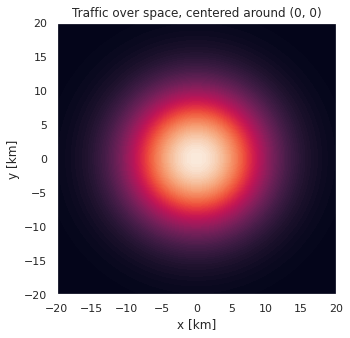

In [5]:

x = np.linspace(-20, 20, 40)
y = np.linspace(-20, 20, 40)
xx, yy = np.meshgrid(x, y)
pl.figure(figsize=(5, 5))
pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100, figsize=(5,5))
pl.title("Traffic over space, centered around (0, 0)")
pl.ylabel("y [km]")
pl.xlabel("x [km]")

In [6]:
# A traffic model gives the traffic at a specified time and place in a city
model = TrafficModel(traffic_over_space, traffic_over_time)

#### Travel time computation
Once a traffic model has been created we can use it to compute the travel time of all the routes that must be performed.  
We assume that a route goes from point A to point B always in a straight line, and we compute the time taken to travel the route by integration
$$
x \rarr x+dx\\
t \rarr t + \mathrm{traffic}(x, t)dx\\
$$
or
$$\partial t / \partial x = \mathrm{traffic}(x, t)$$
While this city model is not realistic, we need to evalutate the scalability of the implemented solutions so we don't need a perfect model of a city.

#### Resource consumption computation
We assume that the resource consumption is only dependent on the travel speed of the vehicle, so we used fuel-specific consumption functions that link the vehicle speed to the resources consumed when travelling at that speed, shown below

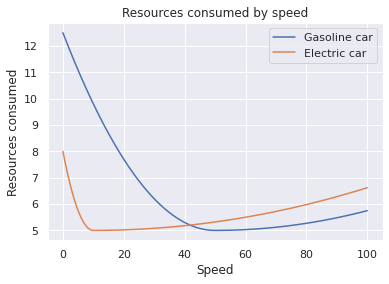

In [7]:
speeds = np.linspace(0, 100, 1000)
pl.plot(speeds, [gasoline_consumption(s) for s in speeds], label="Gasoline car")
pl.plot(speeds, [ev_consumption(s) for s in speeds], label="Electric car")
pl.title("Resources consumed by speed")
pl.xlabel("Speed")
pl.ylabel("Resources consumed")
pl.legend()


The differential equation that governs the fuel consumed is the following
$$\partial \mathrm{resources} / \partial x = \mathrm{consumption}(\mathrm{speed}(x, t))\\
\mathrm{speed}(x, t) = 1 / \mathrm{traffic}(x, t)$$

In [8]:
route = Route(traffic_model=model,
              energy_consumption=gasoline_consumption,
              start=np.array((0., 0.)),
              end=np.array((20., 20.)),
              base_speed=70)

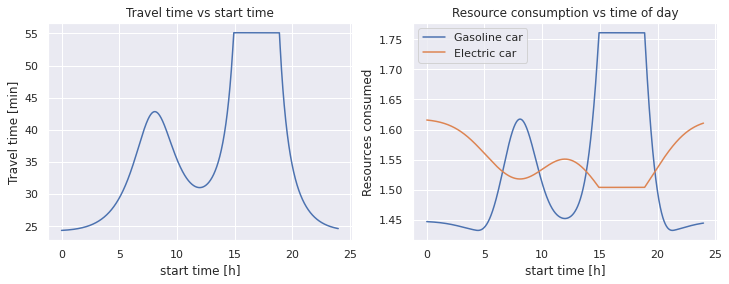

In [9]:
t = np.arange(0, 24*60)

fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].plot(t/60, [route.travel_time(i) for i in t])
axes[0].set_title("Travel time vs start time")
axes[0].set_xlabel("start time [h]")
axes[0].set_ylabel("Travel time [min]")

axes[1].plot(t/60, [route.resources_consumed(i) for i in t], label="Gasoline car")
route.energy_consumption=ev_consumption
axes[1].plot(t/60, [route.resources_consumed(i) for i in t], label="Electric car")
axes[1].set_title("Resource consumption vs time of day")
axes[1].set_xlabel("start time [h]")
axes[1].set_ylabel("Resources consumed")
axes[1].legend()

### Solution

In [17]:
# Problem parameters
n_activities = 30
Q = 2*n_activities
eps = 1.

rng = np.random.default_rng(seed=42)
model = TrafficModel(traffic_over_space, traffic_over_time)

In [11]:
# Generate activities
activities = []
start = rng.uniform(-30, 30, 2)
for i in range(8, 8+n_activities):
    next = rng.uniform(-30, 30, 2)
    route = Route(traffic_model=model,
                  energy_consumption=gasoline_consumption,
                  start=start,
                  end=next,
                  base_speed=70)
    start = next
    # activities.append(
    #     Activity(60*i, 60*(i+2), route.travel_time, route.resources_consumed))
    activities.append(
        Activity(i, 3*(i+2), my_tau, my_rho, lambda x: 3))

discretizer = TimeDiscretizer(eps)

In [12]:
# Solve with TEN
V = []
q = []
for activity in activities:
    times = discretizer.discretize_activity(activity)
    V.append(dict([(i, time) for i, time in enumerate(times)]))
    q.append(dict([(i, activity.resources(time))
             for i, time in enumerate(times)]))

sol = TEN_solve(V, activities, q, Q)
sol

Completion time: 88.59
Resources consumed: 59.98
Nodes visited: 589

In [13]:
# Solve with DDD
sol = DDD_solve(activities, Q, discretizer, TEN_solve)
sol

Completion time: 88.59
Resources consumed: 59.98
Nodes visited: 342

In [14]:
# Solve with Replenishments
sol = TEN_delta(V, activities, q, Q, discretizer)
sol

Completion time: 82.69
Resources consumed: 61.51
Nodes visited: 457

In [15]:
# Solve with DDD with replenishments
sol = DDD_solve(activities, Q, discretizer, TEN_delta)
sol

Completion time: 82.69
Resources consumed: 61.51
Nodes visited: 414

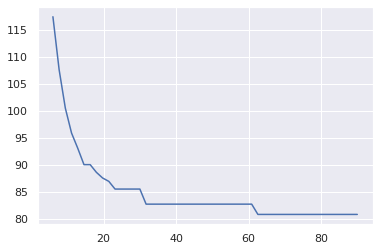

In [29]:
# Plot solution vs resources used
Qs = np.linspace(Q*0.1, Q*1.5, 50)

times = []
for total_resources in Qs:
    sol = TEN_delta(V, activities, q, total_resources, discretizer)
    if sol is not None:
        times.append(sol.completion_time())

pl.plot(Qs[-len(times):], times)

## Gurobi

In [ ]:
tdasp = gb.Model()
x = tdasp.addMVar((n_activities, n_steps), vtype=gb.GRB.BINARY)

In [ ]:
assignment = gb.Model()
assignment.modelSense = gb.GRB.MINIMIZE #declare mimization

# assignment.setParam('OutputFlag', 0) suppress outputs, equivalent of xpress setControl('outputlog', 0)

X = assignment.addVars( [(i,j) for i in range(4) for j in range(4)], vtype=gb.GRB.BINARY) #this way of declare vars does not allow to work with matrix multiplication (X is a tuple dict)

I = range(4)
J = range(4)

costs = np.array([[13,	4,	7, 6],
                	[1,	11,	5, 4],
                  [6,	7,	2, 8],
                  [1,	3,	5, 9]])


for i in I:
  assignment.addConstr( gb.quicksum(X[i,j] for j in J) <= 1) #quicksum is the equivalent to xp.Sum

for j in J:
  assignment.addConstr( gb.quicksum(X[i,j] for i in I) == 1 )

assignment.setObjective( 
    gb.quicksum( costs[i,j]*X[i,j]   for j in J for i in I)
    )   

assignment.optimize() #equivalent to solve() for xpress

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x6f06b897
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.0000000
Presolve time: 0.00s
Presolved: 8 rows, 16 columns, 32 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: objective 1.100000e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.0000000   11.00000  0.00%     -    0s

Explored 1 nodes (